In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import itertools
import tensorflow as tf
from tensorflow import keras
from keras import models
from kerastuner.tuners import RandomSearch
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix



C:\Users\USER\AppData\Local\Temp\ipykernel_15632\4215081863.py:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
#To know if we are using GPU

devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [3]:
IMG_SIZE = 150
CATEGORIES = ["Ceramics","Glass","kitchenware","light bulb", "metal","packing peanuts", "paper","photographs", "plastic","styrofoams", "wood"]
NUM_CLASSES = 11
DATADIR = r"D:/Downloads/datasetah-20221205T033839Z-001/datasetah"

In [4]:
#Loading the dataset

all_images_array = []
all_labels = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)  
    label = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(
                path, img), cv2.IMREAD_COLOR)
            img_array_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
     
            all_images_array.append(img_array_resized)
       
            all_labels.append(label)
        
        except Exception as e:
            pass


In [5]:
# Split the dataset into train and test sets, with percentage of splitting = 70 / 30 respectively
x_train, x_test, y_train, y_test = train_test_split(
    all_images_array, all_labels, test_size=0.30, shuffle=True, random_state=77)

In [6]:
# convert x_train, x_test to numpy array

x_train = np.array(x_train).reshape(-3, IMG_SIZE, IMG_SIZE, 3)
x_test = np.array(x_test).reshape(-3, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)
y_test = np.array(y_test)


x_train.shape

(2620, 150, 150, 3)

In [7]:
# Data normalization to convert features to the same scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
#one hot coding
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

y_test


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [9]:
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_test = (x_test - np.mean(x_test)) / np.std(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (2620, 150, 150, 3)
2620 train samples
1124 test samples


In [10]:
#data augmentation


idg = ImageDataGenerator(width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip=True,
                         vertical_flip=True,
                         cval=0.,
                         channel_shift_range=0.2,
                         shear_range=0.2,
                         
                         

                         )
idg.fit(x_train)

# fit it to the train set
train_set = idg.flow(x_train, y_train, batch_size=32)

In [11]:
#training the model


def build_model(hp):
    model = keras.Sequential()
    


    model.add(keras.layers.AveragePooling2D(6,3,input_shape=(150,150,3)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(0.2))
    for i in range(hp.Int("Conv Layers", min_value=0, max_value=5)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [32,64,128,256]), 3, activation='relu'))
    model.add(keras.layers.MaxPool2D(2,2))

    
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())

    
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [16,32,64, 128, 256, 512]), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [16,32,64, 128,256, 512]), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(11, activation='softmax'))
    opt = SGD(learning_rate = 0.03)
    model.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics= ['accuracy'])
    
    return model


#Using tuner 
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials= 10,
    directory = "./save_model/", #directory for saved model
    project_name='this_model_16',
    overwrite = True
)

log_dir = './log7/'
#Use tuner to search for the best hyperparameters
tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32,callbacks=[keras.callbacks.TensorBoard(log_dir)])



Trial 10 Complete [00h 00m 33s]
val_accuracy: 0.4804270565509796

Best val_accuracy So Far: 0.5551601648330688
Total elapsed time: 00h 05m 40s
INFO:tensorflow:Oracle triggered exit


In [12]:
#To get the best model

best_model = tuner.get_best_models()[0]

In [13]:
#After getting the best model, save the model

filepath = './this_model_17/'
best_model.save(filepath)


checkpoint = tf.train.Checkpoint(best_model)
checkpoint.restore(filepath).expect_partial()

INFO:tensorflow:Assets written to: ./this_model_17/assets


INFO:tensorflow:Assets written to: ./this_model_17/assets


In [14]:
#Load the saved model

best_model = load_model(filepath)


In [15]:
#For callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

In [17]:
"""
steps_per_epoch = batch_size // num_sample
batch_size = 32
num_sample = 2555
"""
# history = best_model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=7, batch_size=32,callbacks=[keras.callbacks.TensorBoard("./log/")])
history = best_model.fit_generator(train_set, steps_per_epoch =81, validation_data=(x_test,y_test), epochs=200,callbacks=[keras.callbacks.TensorBoard(log_dir)])


C:\Users\USER\AppData\Local\Temp\ipykernel_15632\1923395385.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = best_model.fit_generator(train_set, steps_per_epoch =81, validation_data=(x_test,y_test), epochs=200,callbacks=[keras.callbacks.TensorBoard(log_dir)])


Epoch 1/200
81/81 [==============================] - 11s 135ms/step - loss: 1.3859 - accuracy: 0.4965 - val_loss: 1.2073 - val_accuracy: 0.5774
Epoch 2/200
81/81 [==============================] - 11s 132ms/step - loss: 1.3602 - accuracy: 0.5058 - val_loss: 1.1920 - val_accuracy: 0.5658
Epoch 3/200
81/81 [==============================] - 11s 134ms/step - loss: 1.3536 - accuracy: 0.5066 - val_loss: 1.1799 - val_accuracy: 0.5747
Epoch 4/200
81/81 [==============================] - 11s 135ms/step - loss: 1.3381 - accuracy: 0.5089 - val_loss: 1.2108 - val_accuracy: 0.5623
Epoch 5/200
81/81 [==============================] - 11s 134ms/step - loss: 1.3484 - accuracy: 0.5035 - val_loss: 1.1784 - val_accuracy: 0.5890
Epoch 6/200
81/81 [==============================] - 11s 134ms/step - loss: 1.3248 - accuracy: 0.5174 - val_loss: 1.2172 - val_accuracy: 0.5712
Epoch 7/200
81/81 [==============================] - 11s 133ms/step - loss: 1.3267 - accuracy: 0.5158 - val_loss: 1.1664 - val_accuracy:

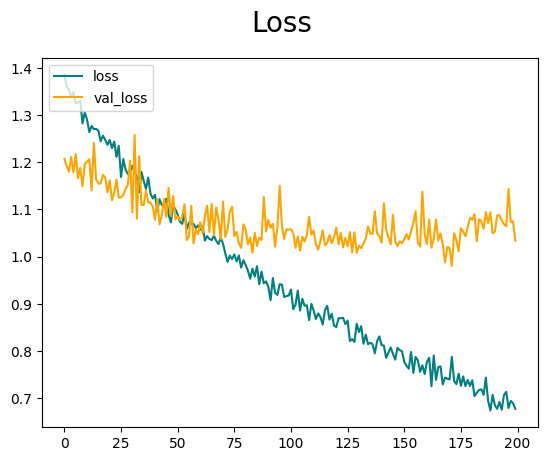

In [18]:
#Graph the relation between val_loss and loss

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

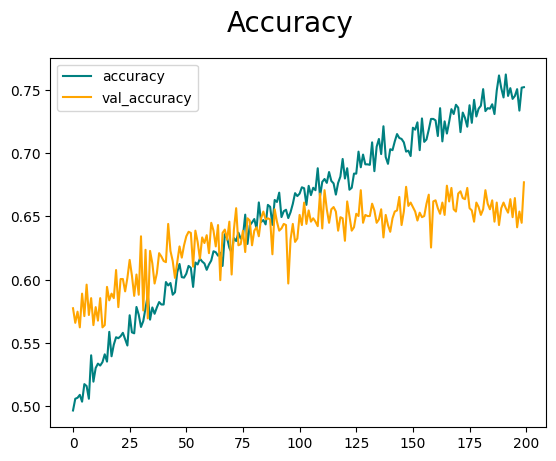

In [19]:
#Graph the relation between val_accuracy and accuracy

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [20]:
#Computing for confusion matric


y_prediction = best_model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_prediction)

#print confusion matrix
print(cm)

#To print precision recall
print(classification_report(y_test,y_prediction))


36/36 [==============================] - 3s 7ms/step
[[ 33   4   0   0   9   0   0   0   5   0   1]
 [  5  87   2   3  23   3   3   0  25   2   4]
 [  0   2 126   0   0   0   0   0   1   0   0]
 [  0   4   1  33   6   4   1   0   4   2   0]
 [  5  17   0   2 231   2   8   2  18   0   1]
 [  0   0   0   1   3  14   1   0   4   0   2]
 [  0   2   0   2  17   5  83   0  22   8   0]
 [  0   0   0   0   3   0   1  14   4   0   0]
 [  5  20   1   4  21   2  27   2 103   6   0]
 [  0   0   0   3   2   1  10   0   2  18   1]
 [  0   0   0   3   7   0   1   0   1   0  19]]
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        52
           1       0.64      0.55      0.59       157
           2       0.97      0.98      0.97       129
           3       0.65      0.60      0.62        55
           4       0.72      0.81      0.76       286
           5       0.45      0.56      0.50        25
           6       0.61      0.60      0.61       

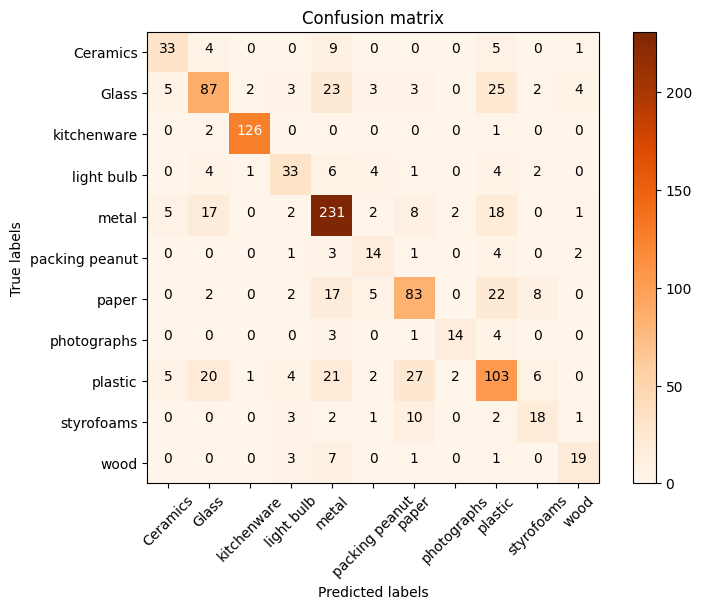

In [21]:
#To plot CM

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    

    
# a tuple for all the class names
target_names = ("Ceramics","Glass","kitchenware","light bulb", "metal","packing peanut", "paper","photographs", "plastic","styrofoams", "wood")
plot_confusion_matrix(cm, target_names)